In [1]:
from torchvision import datasets, transforms

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

mnist_training_data = datasets.MNIST(
    './mnist_data', train=True, download=True,
    transform=transform
)

mnist_test_data = datasets.MNIST(
    './mnist_data', train=False,
    transform=transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 73576995.25it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106352672.37it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19898639.06it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22255290.62it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [2]:
input_size = mnist_training_data[0][0].shape[1] * mnist_training_data[0][0].shape[2]
print(input_size)

784


In [3]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.final_layer = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.hidden1(x))
        x = nn.functional.relu(self.hidden2(x))
        x = nn.functional.log_softmax(self.final_layer(x), dim=1)

        return x


In [4]:
import torch

model = MyModel(input_size, 100)

print(sum([torch.prod(torch.tensor(i.shape)) for i in model.parameters()]))

tensor(89610)


In [5]:
def train(model, train_dataloader, optimizer, print_freq=10):
    model.train()

    train_loss = 0

    for batch_index, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data) # pass the data through the model to get the model output

        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * data.shape[0]

        if not (batch_index % print_freq):
            print(f'Batch [{batch_index}/{len(train_dataloader)}], Loss: {loss.item():.4f}') # print the current training loss of the model.


    return train_loss / len(train_dataloader.dataset)



def test(model, test_dataloader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_index, (data, target) in enumerate(test_dataloader): # for every batch of data and labels in the test dataloader
            output = model(data) # pass the data through the model to get the model output

            test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = correct / len(test_dataloader.dataset)

    return test_loss, test_accuracy

In [6]:
def train_model(model, train_dataloader, test_dataloader, optimizer, num_epochs):
    test_losses = []  # Initialize a list to store test losses
    test_accuracies = []  # Initialize a list to store test accuracies

    for i in range(num_epochs):
        train_loss = train(model, train_dataloader, optimizer)
        test_loss, test_accuracy = test(model, test_dataloader)

        print(
            f'Epoch: {i + 1} | Train loss: {train_loss:.5f} |',
            f'Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.5f}'
        )

        # Append test loss and accuracy to their respective lists
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    return test_losses, test_accuracies


In [7]:
train_dataloader = torch.utils.data.DataLoader(mnist_training_data, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test_data, batch_size=128, shuffle=False)

In [8]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10

Batch [0/469], Loss: 2.2850
Batch [10/469], Loss: 2.1949
Batch [20/469], Loss: 1.9619
Batch [30/469], Loss: 1.4369
Batch [40/469], Loss: 0.8955
Batch [50/469], Loss: 0.7949
Batch [60/469], Loss: 0.4618
Batch [70/469], Loss: 0.4730
Batch [80/469], Loss: 0.3891
Batch [90/469], Loss: 0.4315
Batch [100/469], Loss: 0.4381
Batch [110/469], Loss: 0.4098
Batch [120/469], Loss: 0.4688
Batch [130/469], Loss: 0.3580
Batch [140/469], Loss: 0.4421
Batch [150/469], Loss: 0.3488
Batch [160/469], Loss: 0.5509
Batch [170/469], Loss: 0.5074
Batch [180/469], Loss: 0.4102
Batch [190/469], Loss: 0.3070
Batch [200/469], Loss: 0.3385
Batch [210/469], Loss: 0.3297
Batch [220/469], Loss: 0.6607
Batch [230/469], Loss: 0.2264
Batch [240/469], Loss: 0.2881
Batch [250/469], Loss: 0.3699
Batch [260/469], Loss: 0.2922
Batch [270/469], Loss: 0.3457
Batch [280/469], Loss: 0.3367
Batch [290/469], Loss: 0.2823
Batch [300/469], Loss: 0.3551
Batch [310/469], Loss: 0.2703
Batch [320/469], Loss: 0.2520
Batch [330/469], Loss

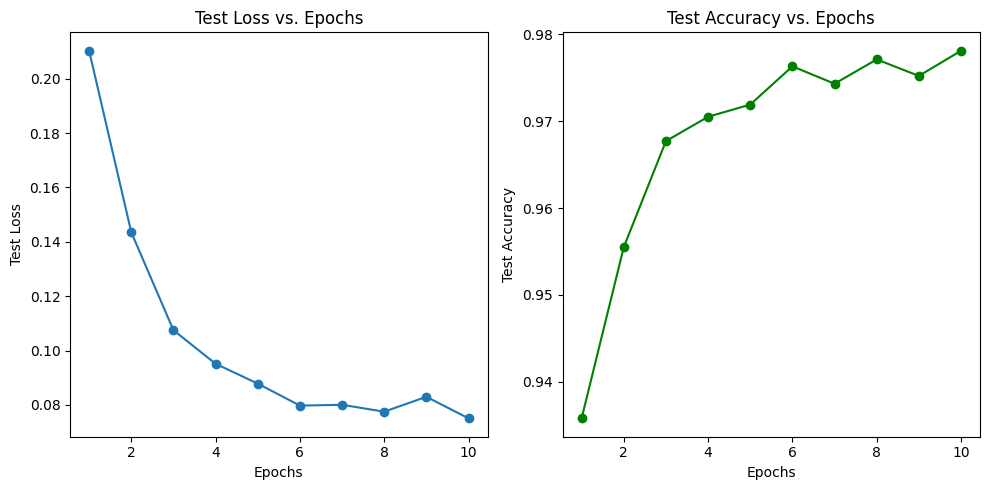

In [9]:
test_losses, test_accuracies = train_model(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, num_epochs=num_epochs)

import matplotlib.pyplot as plt

def plot_results(test_losses, test_accuracies, num_epochs):
    # Generate plots
    plt.figure(figsize=(10, 5))

    # Plot Test Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), test_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Test Loss vs. Epochs')

    # Plot Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs. Epochs')

    plt.tight_layout()
    plt.show()

# Use the plot_results function
plot_results(test_losses, test_accuracies, num_epochs)

**(1) How do PyTorch dataloaders work? How do we get the next batch of data and labels from a dataloader? What is the effect of changing the batch_size argument when we create the dataloaders?**<br>
The dataloaders help in loading and managing datasets for training and testing models. They divide the dataset into smaller batches, making it easier to process large amounts of data. To get the next batch of data and labels from a dataloader, we use a loop to iterate through it. In this code, the for batch_index, (data, target) in enumerate(train_dataloader) line retrieves the next batch of data (data) and its corresponding labels (target) in each iteration. Changing the batch_size argument determines how many samples are processed together in each iteration. With a larger batch size, more samples are processed at once, which can speed up training but may require more memory. A smaller batch size uses less memory but may lead to slower training.

---



**(2) How does the log loss work? Explain in your own words. Why is this a good loss function for the classification task we want to perform?**<br>
The log loss is a measure of how well a classification model predicts the probability of each class; the difference between the predicted probabilities and the actual labels. The log loss is a good choice for classification tasks because it not only penalizes large errors strongly but also provides a smooth and differentiable function for optimization. This makes it suitable for using techniques like gradient descent.

---



**(3) What activation function did you use in your network? Can you explain what the activation function does to its inputs?** <br>
I used the Rectified Linear Unit (ReLU) activation function; which introduces non-linearity. It works by keeping the output as it is if it's positive, and setting it to zero if it's negative. This helps the network learn to approximate more complex functions compared to linear activations.


---



**(4) What happened to the model test loss and accuracy as it was trained? Modify the train_model() function to return a list containing the test loss and accuracy after each epoch, use them to generate a plot of the model test loss and accuracy using matplotlib once training is done, and paste the plot here.** <br>
Test loss began to decrease and accuracy began to decrease, both platueing after several (on certain runs i get jagged graphs, but the general trend still holds):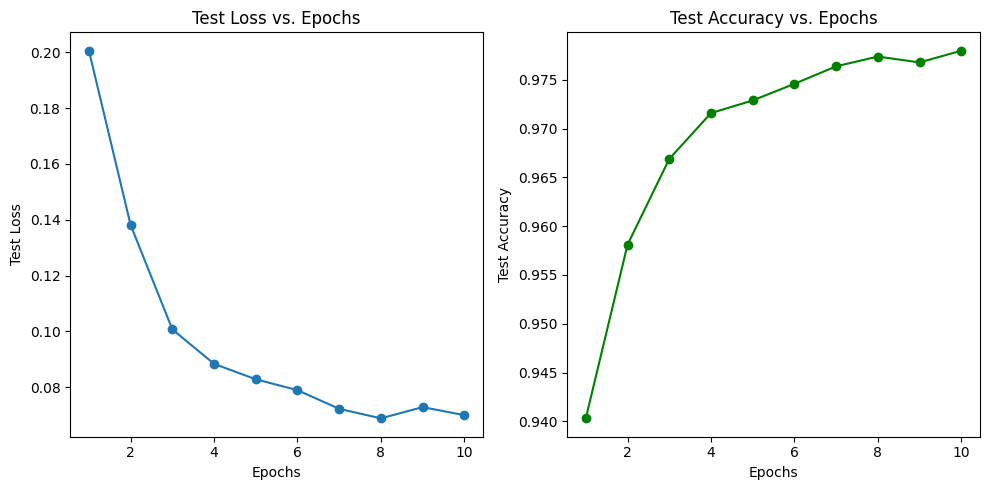

---



**(5) What does the lr parameter you pass in when creating the optimizer do? Try training your model with a few different values of lr (0.0001, 0.01, 1). What happens in each case?** <br>
The lr parameter stands for learning rate, and it determines how much the model's parameters are updated during each iteration of training. A higher learning rate means larger updates, potentially leading to faster convergence but with a risk of overshooting the optimal values, such as with an lr of 1. A lower learning rate means smaller updates, which can lead to slower but more precise convergence.(Tested in different notebook, for new runtime).

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training and test datasets
cifar10_training_data = torchvision.datasets.CIFAR10(
    './cifar10_data', train=True, download=True,
    transform=transform
)

cifar10_test_data = torchvision.datasets.CIFAR10(
    './cifar10_data', train=False,
    transform=transform
)

# Define the CNN model
class AltCNN(nn.Module):
    def __init__(self):
        super(AltCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
alt_cnn_model = AltCNN()

# Define the dataloaders
train_dataloader_cifar10 = torch.utils.data.DataLoader(
    cifar10_training_data, batch_size=128, shuffle=True
)

test_dataloader_cifar10 = torch.utils.data.DataLoader(
    cifar10_test_data, batch_size=128, shuffle=False
)

# Define the optimizer
optimizer_cifar10 = optim.SGD(alt_cnn_model.parameters(), lr=0.01, momentum=0.9)

# Training function
def train_cifar10_alt(model, train_dataloader, optimizer, print_freq=10):
    model.train()
    train_loss = 0

    for batch_index, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.shape[0]

        if not (batch_index % print_freq):
            print(f'Batch [{batch_index}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    return train_loss / len(train_dataloader.dataset)

# Testing function
def test_cifar10_alt(model, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_index, (data, target) in enumerate(test_dataloader):
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_accuracy = correct / len(test_dataloader.dataset)

    return test_loss, test_accuracy

# Training the model
def train_model_cifar10_alt(model, train_dataloader, test_dataloader, optimizer, num_epochs):
    test_losses = []
    test_accuracies = []
    for i in range(num_epochs):
        train_loss = train_cifar10_alt(model, train_dataloader, optimizer)
        test_loss, test_accuracy = test_cifar10_alt(model, test_dataloader)

        print(
            f'Epoch: {i + 1} | Train loss: {train_loss:.5f} |',
            f'Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.5f}'
        )

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    return test_losses, test_accuracies

# Train the model
num_epochs_cifar10 = 10

train_model_cifar10_alt(
    model=alt_cnn_model,
    train_dataloader=train_dataloader_cifar10,
    test_dataloader=test_dataloader_cifar10,
    optimizer=optimizer_cifar10,
    num_epochs=num_epochs_cifar10
)


Files already downloaded and verified
Batch [0/391], Loss: 2.3075
Batch [10/391], Loss: 2.3041
Batch [20/391], Loss: 2.2988
Batch [30/391], Loss: 2.2949
Batch [40/391], Loss: 2.2818
Batch [50/391], Loss: 2.2766
Batch [60/391], Loss: 2.2613
Batch [70/391], Loss: 2.2234
Batch [80/391], Loss: 2.1187
Batch [90/391], Loss: 2.0613
Batch [100/391], Loss: 2.0874
Batch [110/391], Loss: 2.0932
Batch [120/391], Loss: 2.0612
Batch [130/391], Loss: 2.0297
Batch [140/391], Loss: 2.0351
Batch [150/391], Loss: 1.9842
Batch [160/391], Loss: 2.0493
Batch [170/391], Loss: 1.9394
Batch [180/391], Loss: 1.9613
Batch [190/391], Loss: 2.1373
Batch [200/391], Loss: 1.8384
Batch [210/391], Loss: 1.7218
Batch [220/391], Loss: 1.9310
Batch [230/391], Loss: 1.9424
Batch [240/391], Loss: 1.8637
Batch [250/391], Loss: 1.8840
Batch [260/391], Loss: 1.8079
Batch [270/391], Loss: 1.8252
Batch [280/391], Loss: 1.6541
Batch [290/391], Loss: 1.7920
Batch [300/391], Loss: 1.7468
Batch [310/391], Loss: 1.8834
Batch [320/39

([1.6444359216690063,
  1.3941218757629394,
  1.2675016744613647,
  1.1156316541671754,
  1.0357959911346435,
  0.9430306169509888,
  0.8790109735488891,
  0.8303210919380188,
  0.8308888206481934,
  0.7656069904327393],
 [0.394,
  0.4978,
  0.5414,
  0.5987,
  0.6358,
  0.6732,
  0.6903,
  0.7093,
  0.7038,
  0.7353])

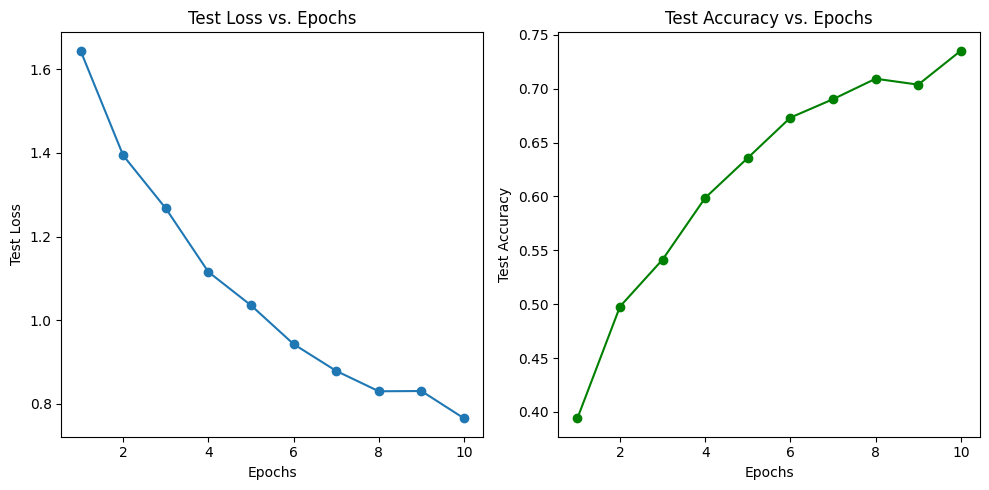

In [14]:
# Use the plot_results function
plot_results([1.6444359216690063,
  1.3941218757629394,
  1.2675016744613647,
  1.1156316541671754,
  1.0357959911346435,
  0.9430306169509888,
  0.8790109735488891,
  0.8303210919380188,
  0.8308888206481934,
  0.7656069904327393], [0.394,
  0.4978,
  0.5414,
  0.5987,
  0.6358,
  0.6732,
  0.6903,
  0.7093,
  0.7038,
  0.7353], num_epochs)